# pNEUMA dataset
https://open-traffic.epfl.ch/

## References

Emmanouil Barmpounakis, Nikolas Geroliminis,
On the new era of urban traffic monitoring with massive drone data: The pNEUMA large-scale field experiment,
Transportation Research Part C: Emerging Technologies,
Volume 111,
2020,
Pages 50-71,
ISSN 0968-090X,
https://doi.org/10.1016/j.trc.2019.11.023.

In [284]:
import os
import csv
import glob
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [213]:
import numpy as np
import osmnx as ox
import datetime as dt
import networkx as nx
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd

In [28]:
from rtree import index
from datetime import timedelta
from geopandas import GeoDataFrame
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString
from ipywidgets import IntSlider, interact    

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
#import hdbscan
#from pydmd import DMD

In [7]:
def read_csv(path):
    metadata_cols = [
        'track_id',
        'type',
        'traveled_d',
        'avg_speed',
    ]
    data_cols = [
        'lat',
        'lon',
        'speed',
        'lat_acc',
        'lon_acc',
        'time',
        'track_id',
    ]

    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols) - 1

    metadata_rows = list()
    data_rows = list()

    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [
                float(item) for item in row[metadata_colsize:] if len(item) > 0
            ]
            for i in range(0, len(data_traj), data_colsize):
                data_row = data_traj[i:i + data_colsize] + [track_id]
                data_rows.append(data_row)

    data = pd.DataFrame(data_rows, columns=data_cols)
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

In [8]:
files = []
root = os.getcwd()
path = './data/pNEUMA/'
os.chdir(path)
for file in glob.glob("*.csv"):
    files.append(file)
os.chdir(root)
urlpath = f'{path}{file}'
print(urlpath)

./data/pNEUMA/20181024_d1_0830_0900.csv


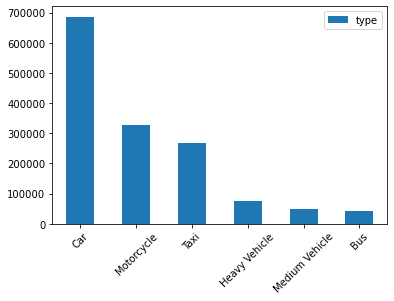

In [9]:
metadata, data = read_csv(urlpath)
df = pd.merge(metadata, data, left_index=True, right_on='track_id')
df['traveled_d'] = df.traveled_d.astype(float)
ax = df.type.value_counts(dropna=False).plot.bar(rot=45, legend=True)

In [10]:
sample = df#[(df.track_id <= 100)]
sample['timestamp'] = sample.apply(
    lambda x: dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=x.time),
    axis=1)
sample = sample.set_index('timestamp')

In [11]:
# Initialize points in ETRS89 reference system.
geolocations = gpd.GeoDataFrame(sample,
                                geometry=gpd.points_from_xy(
                                    sample.lon,
                                    sample.lat,
                                    crs={'init': 'epsg:4326'}))
geolocations.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
%%time
trajectories = []
for key, values in geolocations.groupby(['track_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 922 trajectories
CPU times: user 1.18 s, sys: 31.7 ms, total: 1.21 s
Wall time: 1.21 s


In [14]:
traj_collection = mpd.TrajectoryCollection(trajectories[:])
print(traj_collection)

TrajectoryCollection with 922 trajectories


In [15]:
# Convert to Pseudo-Mercator for cartography.
geolocations = geolocations.to_crs(epsg=3857)
geolocations.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t >= traj.get_start_time() and t <= traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id),
                'type': traj.df['type'].values[0]
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [17]:
# Extract x, y and c from geopandas.
lat = geolocations.geometry.y
lon = geolocations.geometry.x
c = geolocations.speed

In [18]:
# Specify maptiles source.
basemap = ctx.providers.CartoDB.DarkMatter

In [19]:
@interact(i=(0, geolocations.time.max(), 0.5))
def plot(i=0):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(lon, lat, c=c, s=0.05, ec=None, cmap='plasma')

    t = dt.datetime(2018, 10, 24, 8, 30) + timedelta(seconds=i)
    points = get_locations_at_timestamps(traj_collection, t)
    points = points.to_crs(epsg=3857)
    sizes = {
        'Car': 30,
        'Taxi': 30,
        'Bus' : 90,
        'Motorcycle': 5,
        'Medium Vehicle': 50,
        'Heavy Vehicle': 90
    }
    colors = {
        'Car': 'white',
        'Taxi': 'gold',
        'Bus' : 'royalblue',
        'Motorcycle': 'crimson',
        'Medium Vehicle': 'saddlebrown',
        'Heavy Vehicle': 'darkgreen'
    }
    points['sizes'] = points['type'].map(sizes)
    points['colors'] = points['type'].map(colors)
    lat1 = points.geometry.y
    lon1 = points.geometry.x
    sizes = points['sizes']
    colors = points['colors']
    ax.scatter(lon1, lat1, s=sizes, ec=None, c=colors)
    ax.set_axis_off()
    ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

interactive(children=(FloatSlider(value=0.0, description='i', max=818.8, step=0.5), Output()), _dom_classes=('…

In [472]:
from leuvenmapmatching.map.inmem import InMemMap

map_con = InMemMap("myosm", use_latlon=True)

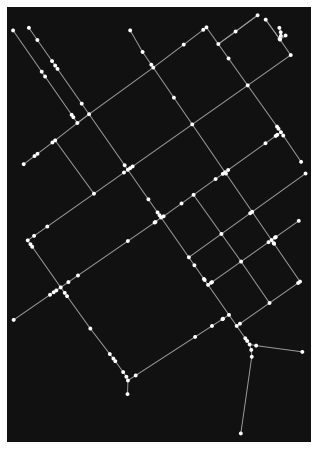

In [473]:
G = ox.graph_from_bbox(sample.lat.max(),
                       sample.lat.min(),
                       sample.lon.max(),
                       sample.lon.min(),
                       simplify=False,
                       retain_all=False,
                       truncate_by_edge=True,
                       clean_periphery = False,
                       network_type='drive')
G_projected = ox.project_graph(G)
ax = ox.plot_graph(G_projected)

In [474]:
nodes, streets = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [475]:
streets.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [476]:
for nid, row in nodes[['x', 'y']].iterrows():
    map_con.add_node(nid, (row['y'], row['x']))
for u, v, _ in G.edges:
    map_con.add_edge(u, v)

In [477]:
streets = streets.to_crs(epsg=3857).reset_index()
streets['bbox'] = streets.apply(lambda row: row['geometry'].bounds, axis=1)

In [616]:
trip = traj_collection.trajectories[30].df.to_crs(epsg=3857)
trip

type  traveled_d  avg_speed   lat   lon  speed  \
timestamp                                                                
2018-10-24 08:30:00.000  Car      381.07  28.820679 37.98 23.74  35.89   
2018-10-24 08:30:00.040  Car      381.07  28.820679 37.98 23.74  35.89   
2018-10-24 08:30:00.080  Car      381.07  28.820679 37.98 23.74  35.88   
2018-10-24 08:30:00.120  Car      381.07  28.820679 37.98 23.74  35.87   
2018-10-24 08:30:00.160  Car      381.07  28.820679 37.98 23.74  35.87   
...                      ...         ...        ...   ...   ...    ...   
2018-10-24 08:30:47.440  Car      381.07  28.820679 37.98 23.74  19.15   
2018-10-24 08:30:47.480  Car      381.07  28.820679 37.98 23.74  19.18   
2018-10-24 08:30:47.520  Car      381.07  28.820679 37.98 23.74  19.21   
2018-10-24 08:30:47.560  Car      381.07  28.820679 37.98 23.74  19.24   
2018-10-24 08:30:47.600  Car      381.07  28.820679 37.98 23.74  19.28   

                         lat_acc  lon_acc  time  track_id  \
timestamp                                                   
2018-10-24 08:30:00.000    -0.05    -0.00  0.00        31   
2018-10-24 08:30:00.040    -0.04    -0.00  0.04        31   
2018-10-24 08:30:00.080    -0.04    -0.00  0.08        31   
2018-10-24 08:30:00.120    -0.04    -0.01  0.12        31   
2018-10-24 08:30:00.160    -0.03    -0.01  0.16        31   
...                          ...      ...   ...       ...   
2018-10-24 08:30:47.440     0.41     0.11 47.44        31   
2018-10-24 08:30:47.480     0.42     0.10 47.48        31   
2018-10-24 08:30:47.520     0.42     0.10 47.52        31   
2018-10-24 08:30:47.560     0.43     0.09 47.56        31   
2018-10-24 08:30:47.600     0.45     0.09 47.60        31   

                                                geometry  
timestamp                                                 
2018-10-24 08:30:00.000  POINT (2642246.817 4576583.639)  
2018-10-24 08:30:00.040  POINT (2642247.039 4576583.215)  
2018-10-24 08:30:00.080  POINT (2642247.373 4576582.792)  
2018-10-24 08:30:00.120  POINT (2642247.596 4576582.368)  
2018-10-24 08:30:00.160  POINT (2642247.930 4576581.944)  
...                                                  ...  
2018-10-24 08:30:47.440  POINT (2642484.707 4576169.003)  
2018-10-24 08:30:47.480  POINT (2642484.595 4576168.720)  
2018-10-24 08:30:47.520  POINT (2642484.595 4576168.579)  
2018-10-24 08:30:47.560  POINT (2642484.595 4576168.297)  
2018-10-24 08:30:47.600  POINT (2642484.484 4576168.014)  

[1191 rows x 11 columns]

In [617]:
def build_rtree_index_edges(gpd_edges):
    '''
    build a r-tree index for road segments
    input:
        gpd_edges: a geopandas dataframe that contains road segments (edge geometries)
    output:
        idx: a r-tree index of the edge geometries
    '''
    # r-tree index for edges
    p = index.Property()
    idx = index.Index(properties=p)
    for i, row in gpd_edges.iterrows():
        idx.insert(i, row['bbox'], obj=row)
    return idx

In [618]:
def query_k_nearest_road_segments(edge_idx, point, k):
    '''
    query k-nearest road segments of a given point
    :param edge_idx: the road segments r-tree index
    :param point: the given point
    :param k: the number of segments needed to query
    :return: k candidates as a pandas DataFrame
    '''
    candidates = pd.DataFrame(columns=('distance', 'u', 'v', 'proj_point',
                                       'road'))
    hits = edge_idx.nearest((point.x, point.y, point.x, point.y),
                            k,
                            objects=True)
    for item in hits:
        results = nearest_points(point, item.object['geometry'])
        d = point.distance(results[1])
        s = pd.Series({
            'distance': d,
            'u': item.object['u'],
            'v': item.object['v'],
            'proj_point': results[1],
            'road': item.object
        })
        candidates = candidates.append(s, ignore_index=True)
    candidates.sort_values(by='distance', axis=0, inplace=True)
    return candidates

In [619]:
def find_candidates(trip, road_idx, k):
    '''
    given a trip, find candidates points for each point in the trip
    :param trip: a GPS trajectory (without coordinates transform)
    :param road_idx: road segments r-tree index of the corresponding road network
    :param k: the number of candidates
    :return: the trip with candidates
    '''
    candi_list = []
    for i in range(0, len(trip)):
        candidates = query_k_nearest_road_segments(road_idx,
                                                   trip.iloc[i]['geometry'], k)
        candi_list.append(candidates)
    trip['candidates'] = candi_list
    return trip

In [620]:
def normal_distribution(mu, sigma, x):
    '''
    calculate normal distribution values
    input:
    mu: the mean value
    sigma; the standard deviation
    x: the given variables
    output:
    the probabilities of given input variables x
    '''
    return 1.0 / (sigma * np.sqrt(2 * np.pi)) * (np.exp(-1.0 *
                                                        (np.array(x) - mu)**2 /
                                                        (2 * sigma**2)))

In [621]:
def calculate_observation_probability(trip, mu, sigma):
    for i in range(len(trip)):
        trip.iloc[i]['candidates']['observation prob'] = trip.iloc[i][
            'candidates'].apply(
                lambda row: normal_distribution(mu, sigma, row['distance']),
                axis=1)
    return trip

In [622]:
def get_edge_info(edges, from_id, to_id):
    results = edges[(edges['u'] == from_id) & (edges['v'] == to_id)]
    if len(results) > 1:
        if results.iloc[0]['length'] < results.iloc[1]['length']:
            return results.iloc[0]
        else:
            return results.iloc[1]
    else:
        return results.iloc[0]

In [623]:
def network_distance(G, edges, candidate1, candidate2):
    '''
    calculate network distance between two candidates
    input:
    G: the road network
    candidate1: a candidate (from, to, proj_point, distance) represents as a pandas series 
    candidate2: a candidate (from, to, proj_point, distance) represents as a pandas series
    output:
    the shortest path distance between the given two candidates
    '''
    d = 0
    sp_edges = []
    p1 = candidate1['proj_point']
    edge1 = candidate1['road']
    p2 = candidate2['proj_point']
    edge2 = candidate2['road']
    if edge1['geometry'] == edge2['geometry']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)
        d = d3 - d2
        if d < 0: d = 0
        sp_edges.append(edge1)
    elif candidate1['u'] == candidate2['v']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['length'] - edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)
        d = d2 + d3
        sp_edges.append(edge1)
        sp_edges.append(edge2)
    else:
        # part 1 of the distance
        source = candidate1.u
        target = candidate2.v
        try:
            sp = nx.shortest_path(G, source, target, weight='length')
            d1 = nx.shortest_path_length(G, source, target, weight='length')
        except Exception as err:
            #print(err)
            d = 1000
        else:
            # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
            d2 = edge1['length'] - edge1['geometry'].project(p1)
            # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
            d3 = edge2['geometry'].project(p2)
            d = d1 + d2 + d3
            for i in range(len(sp) - 1):
                sp_edges.append(get_edge_info(edges, sp[i], sp[i + 1]))
    return d, sp_edges

In [624]:
def calculate_transition_probability(beta, gc_distance, sp_distance):
    diff = abs(gc_distance-sp_distance)
    return math.exp(-diff/beta) / beta

In [625]:
def calculate_weights_between_candidates(G, streets, trip, idx, beta):
    '''
    calculate weights between the idx-1 and the idx th points's candidates
    input:
    idx: the idx-th sampling point (idx > 0)
    '''
    # the great circle distance (euclidean distance) between the idx-1 and the idx-th sampling points
    great_circle_distance = trip.iloc[idx]['geometry'].distance(
        trip.iloc[idx - 1]['geometry'])
    #print great_circle_distance
    # the time gap between the idx-1 and the idx-th sampling points
    delta = trip.iloc[idx].name - trip.iloc[idx - 1].name
    weights_list = []
    for i in range(len(trip.iloc[idx]['candidates'])):
        weights = pd.DataFrame(columns=('from_id', 'to_id', 'sp distance',
                                        'gc distance', 'sp edges',
                                        'transition prob'))
        for j in range(len(trip.iloc[idx - 1]['candidates'])):
            sp_distance, sp_edges = network_distance(
                G, streets, trip.iloc[idx - 1]['candidates'].iloc[j],
                trip.iloc[idx]['candidates'].iloc[i])
            # transmission probility
            t_p = calculate_transition_probability(beta, great_circle_distance,
                                                   sp_distance)
            s = pd.Series({
                'from_id': j,
                'to_id': i,
                'sp distance': sp_distance,
                'gc distance': great_circle_distance,
                'sp edges': sp_edges,
                'transition prob': t_p
            })
            weights = weights.append(s, ignore_index=True)
            weights[['from_id', 'to_id']] = weights[['from_id',
                                                     'to_id']].astype(int)
        weights_list.append(weights)
    return weights_list

In [626]:
# find the optimal path viterbi algorithm
def find_optimal_candidates(road_graph_utm, gpd_edges_utm, trip, beta):
    # forward search
    f = [list(trip.iloc[0]['candidates'].apply(lambda x: math.log(x['observation prob']), axis=1))]
    #f.append(list(trip.iloc[0]['candidates']['observation prob']))
    pre = []
    pre.append([])
    weights = []
    weights.append([])
    for i in trange(1, len(trip)):
        f_i = []
        pre_i = []
        weights_list = calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, i, beta)
        for k in range(len(weights_list)):
            f_sum = []
            for j in range(len(weights_list[k]['transition prob'])):
                from_id = weights_list[k].iloc[j]['from_id']
                #f_sum.append(f[-1][from_id]*weights_list[k].iloc[j]['transition prob']) 
                f_sum.append(f[-1][from_id]+ math.log(weights_list[k].iloc[j]['transition prob']))
            #print(f_sum)
            weights_list[k]['weight_sum'] = f_sum
            pre_i.append(f_sum.index(max(f_sum)))
            #f_i.append(max(f_sum)*trip.iloc[i]['candidates']['observation prob'].iloc[k])
            f_i.append(max(f_sum)+ math.log(trip.iloc[i]['candidates']['observation prob'].iloc[k]))
        f.append(f_i)
        pre.append(pre_i)
        weights.append(weights_list)
        #print(i, f_i)
        #print(i, pre_i)
    # backward search
    rlist=[]
    c = f[-1].index(max(f[-1]))
    rlist.append(c)
    for i in range( len(pre) - 1, 0, -1):
        c = pre[i][c]
        rlist.insert(0,c)
    #print rlist
    trip['weights'] = weights
    trip['optimal candidate'] = rlist
    return trip

In [627]:
def find_optimal_mapping_points(trip):
    points = []
    idxs = trip['optimal candidate']
    candidates = trip['candidates']
    for i in range(len(trip)):
        idx = idxs.iloc[i]
        #print idx
        #print candidates.iloc[i].iloc[idx]['proj_point']
        points.append(candidates.iloc[i].iloc[idx]['proj_point'])
    return gpd.GeoSeries(points)

In [628]:
k = 3
mu = 0
sigma = 10
idx = build_rtree_index_edges(streets)
traj = find_candidates(trip, idx, k)
traj = calculate_observation_probability(traj, mu, sigma)

In [629]:
df = find_optimal_candidates(G, streets, traj, 100)

  0%|          | 0/1190 [00:00<?, ?it/s]

In [630]:
df = find_optimal_mapping_points(df)

In [631]:
proj_points = []
for candidate in traj.candidates[:]:
    proj_points.append(candidate.proj_point.ravel())

In [632]:
proj_points = np.concatenate(proj_points).ravel()
candidates = gpd.GeoDataFrame(proj_points, geometry=0)

In [633]:
# Extract x, y and c from geopandas.
lat = candidates.geometry.y
lon = candidates.geometry.x

lat2 = traj.geometry.y
lon2 = traj.geometry.x
lat1 = lat2[0]
lon1 = lon2[0]
lat3 = df.geometry.y
lon3 = df.geometry.x

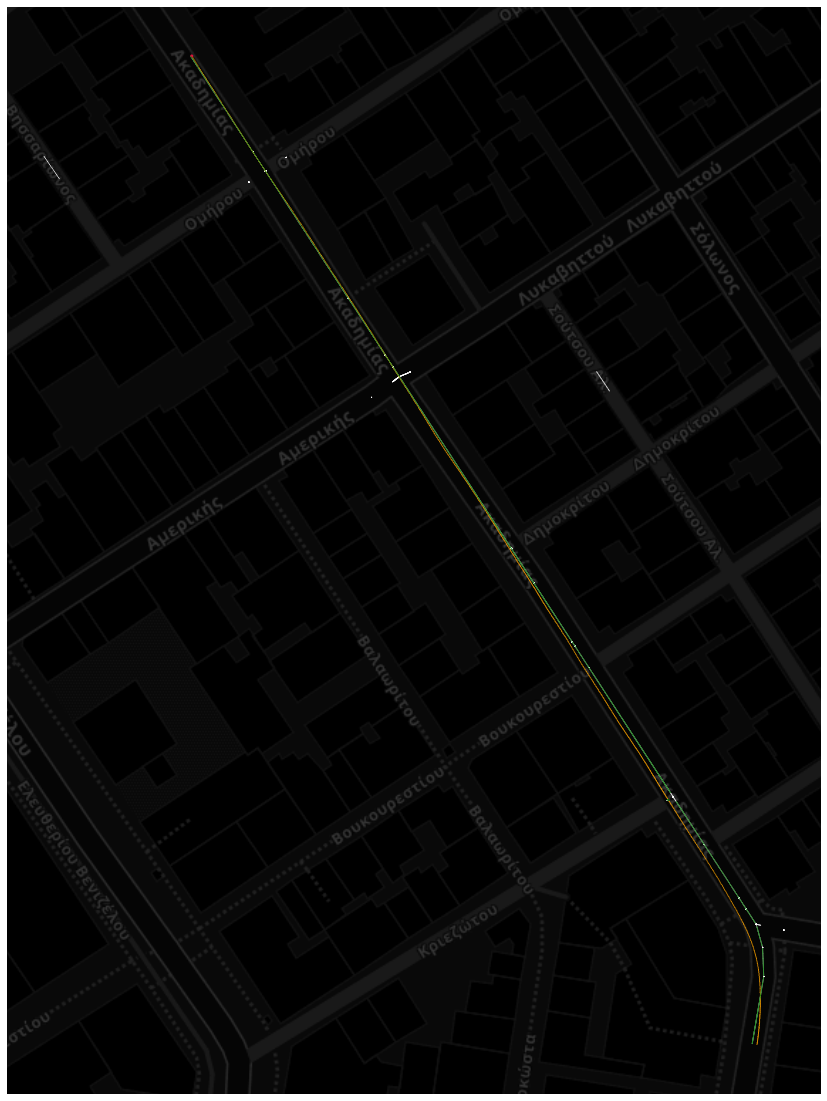

In [636]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(lon, lat, s=1, ec=None, c='white')
ax.scatter(lon2, lat2, s=1, ec=None, c='orange', zorder=1)
ax.scatter(lon1, lat1, s=10, ec=None, c='crimson', zorder=2)
ax.scatter(lon3, lat3, s=1, ec=None, c='green', zorder=4)
ax.set_axis_off()
ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)

*****************************

Lowered zoom level to keep map size reasonable. (z = 17)


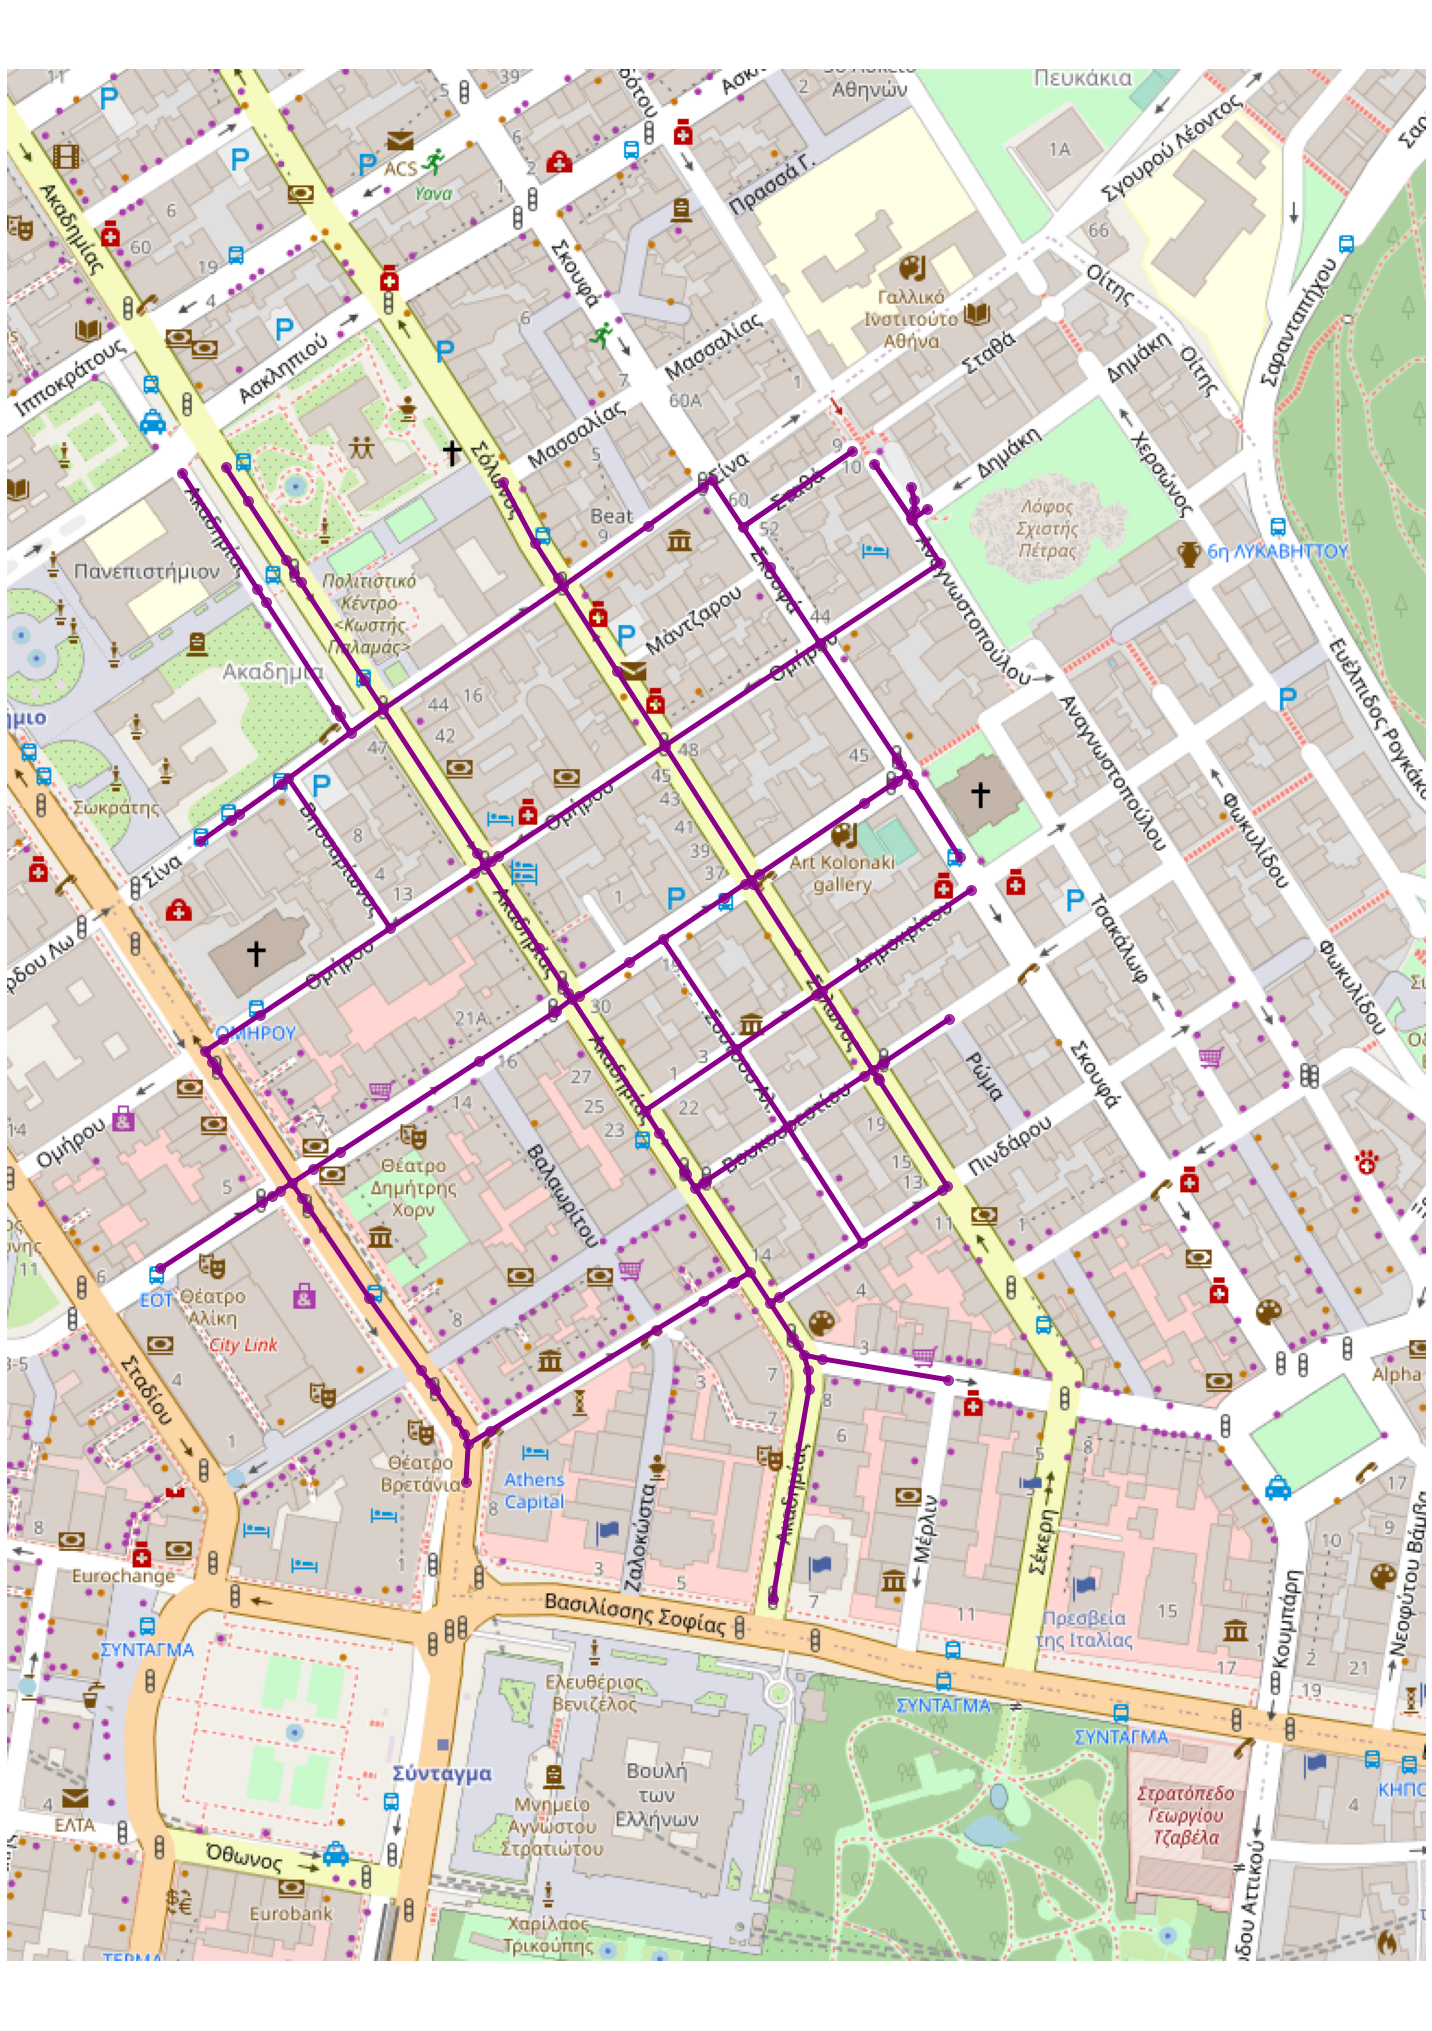

In [237]:
from leuvenmapmatching import visualization as mmviz
mmviz.plot_map(map_con,
               matcher=None,
               show_labels=False,
               show_matching=False,
               show_graph=True,
               use_osm=True,
               linewidth=5)
plt.show()

In [43]:
import folium
style = {'weight':2}
m = folium.Map([sample.lat.mean(), sample.lon.mean()],
               zoom_start=16.5,
               max_zoom=20,
               tiles='CartoDb dark_matter')
folium.GeoJson(streets.geometry, style_function=lambda x: style).add_to(m)
m